# 6202 Machine Learning - 1: 2019 Data Science Bowl

### PBS KIDS Measure Up App Assesment Result Prediction

<img src="./Images/Landing Page.png">


# Table Of Content: <a id="toc"></a>

* [Introduction](#introduction)
* [Link to Dataset](#data_url)
* [Data Description](#data_description) 
* [Data Preprocessing](#data_preprocessing)
    * Handling Identifiers
    * Deleting Rows without any assessment records.
    * Deleting Columns which are not useful for analysis
    * Cross referencing training data with training label data
    * Handling Categorical Variables
    * Feature Engineering
* [Exploratory Data Analysis](#eda)
* [Modelling](#modelling)
    - Separating into train and test data
    - Data Sampling
    - Data Scaling
    - Hyper parameter tuning and Model Selection
      - Creating pipelines
      - Creating dictionary of parameter grids
      - Hyper parameter tuning
    - Feature Importance
    - Ensembling Methods
* [Conclusion](#conclusion)

In [0]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set working directory
abspath = '/content/drive/My Drive/Colab Notebooks/ML-Term-Project'

import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline 
import seaborn as sns

# Set matplotlib sizes
plt.rc("font", size=20)
plt.rc("axes", titlesize=20)
plt.rc("axes", labelsize=20)
plt.rc("xtick", labelsize=20)
plt.rc("ytick", labelsize=20)
plt.rc("legend", fontsize=20)
plt.rc("figure", titlesize=20)

pd.set_option("max_columns", 500)

In [0]:
# read the input files
train = pd.read_csv(abspath + "/data/train.csv")
train_labels = pd.read_csv(abspath + "/data/train_labels.csv")
specs = pd.read_csv(abspath + "/data/specs.csv")

## Introduction <a id="introduction"></a>

The "KIDS Measure Up" app is an educational application which helps kids explore and learn fundamental math concepts in a fun and interactive manner.

The dataset contains game analytics for KIDS Measure Up! app. In this app, children navigate a map and complete various levels, which may be activities, video clips, games, or assessments. 

Each assessment is designed to test a child's comprehension of a certain set of measurement-related skills. There are five assessments: Bird Measurer, Cart Balancer, Cauldron Filler, Chest Sorter, and Mushroom Sorter.

The purpose of our analysis is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment and hence predicting the accuracy group for user. The outcomes of this analysis are grouped into 4 groups (labeled accuracy_group in the data):

- 3: the assessment was solved on the first attempt
- 2: the assessment was solved on the second attempt
- 1: the assessment was solved after 3 or more attempts
- 0: the assessment was never solved

## Data Description:<a id="data_description"></a>

The data is downloaded from the following url: https://www.kaggle.com/c/data-science-bowl-2019/data. There are 3 files which we are using, they are train.csv, train_label.csv and specs.csv.

The **train** data contains the historical gameplay for the application and the columns present in the train data are:

- **event_id** - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.
- **game_session** - Randomly generated unique identifier grouping events within a single game or video play session.
- **timestamp** - Client-generated datetime
- event_data - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise fields are determined by the event type.
- **installation_id** - Randomly generated unique identifier grouping game sessions within a single installed application instance.
- **event_count** - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
- **event_code** - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.
- **game_time** - Time in milliseconds since the start of the game session. Extracted from event_data.
- **title** - Title of the game or video.
- **type** - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
- **world** - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

The **train_label** data contains the target variables for the training rows which have type = Assessment.

The **specs** file contains specification for various events. This file was not used extensively in our analysis.

## Data Preprocessing:<a id="data_preprocessing"></a>

We will now preprocess the train data to create an aggregated dataframe which we will use for creating statistical models. We will also perform feature engineering which will be discussed further. 

### Handling Identifiers

We will first identify which columns are identifiers in the train dataset.

In [0]:
def id_checker(df):
    """
    The identifier checker

    Parameters
    ----------
    df : dataframe
    
    Returns
    ----------
    The dataframe of identifiers
    """

    # Get the identifiers
    df_id = df[
        [
            var
            for var in df.columns
            if df[var].nunique(dropna=True) == df[var].notnull().sum()
        ]
    ]

    return df_id

<IPython.core.display.Javascript object>

In [0]:
# Call id_checker on df
df_id = id_checker(train)

<IPython.core.display.Javascript object>

In [0]:
df_id.shape

(11341042, 0)

<IPython.core.display.Javascript object>

Thus based on shape of df_id we conclude that no one column is identifier column, instead by the data description we observe that in the train data the combination of game session and installation id act as unique identifiers. We will remove them before creating [models](#modelling), for now we keep them for aggregation purposes.


### Deleting Rows without any assessment records.

Since we want to predict the user's accuracy group for an assessment, we want to restrict training data which is relevant to predicting accuracy group.

Thus we will delete those user which have not taken assessment, because they will not contribute in prediction.

The total number unique installation ids or users in training data is:

In [0]:
total_installation_ids = len(train["installation_id"].unique())
print(total_installation_ids)

17000


<IPython.core.display.Javascript object>

The total number of installation ids who have taken the assessment:

In [0]:
# installation ids who have taken assessment
installation_ids_assessment = train[train["type"] == "Assessment"][
    "installation_id"
].unique()

<IPython.core.display.Javascript object>

In [0]:
print(len(installation_ids_assessment))

4242


<IPython.core.display.Javascript object>

The number of installation ids which have not taken assessment is:

In [0]:
total_installation_ids - len(installation_ids_assessment)

12758

<IPython.core.display.Javascript object>

Thus we retain only those installation ids which have taken assessment from the training data.

In [0]:
train_fil = train[train["installation_id"].isin(installation_ids_assessment)].copy(
    deep=True
)

<IPython.core.display.Javascript object>

After retaining the installation ids who have taken assessment the shape of training data is:

In [0]:
train_fil.shape

(8294138, 11)

<IPython.core.display.Javascript object>

### Deleting Columns which are not useful for analysis:<a id="delete_columns"></a>

We delete the event_code column and event_data column since they are not useful in our analysis.

In [0]:
train_fil.drop(["event_code", "event_data"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

### Cross referencing training data with training label data <a id="cross_reference_train_train_label"></a>

We will now check whether the all the training data has corresponding train label. For this we will match the train data with train label data using **game_session** column and **installation_id** column.

**Cross referencing using game_session:**

Count of unique game sessions in training data are:

In [0]:
# game session attempts in the train dataset
game_Session_train = np.array(
    train_fil[train_fil["type"] == "Assessment"]["game_session"].unique()
)
print(len(game_Session_train))

21239


<IPython.core.display.Javascript object>

Count of unique game sessions in train label data:

In [0]:
# Total Number of game session in train labels
game_Session_labels = np.array(train_labels["game_session"].unique())
print(len(game_Session_labels))

17690


<IPython.core.display.Javascript object>

We notice that the train label data has fewer game session ids than the train data, thus the train data contains rows which do not have labels assigned to them. The train data without labels are *noise* and thus we remove them.

In [0]:
# To get assessment attempts records that are both common in train set & train lables
uncommon_game_Session = np.setdiff1d(game_Session_train, game_Session_labels)
print(len(uncommon_game_Session))

3549


<IPython.core.display.Javascript object>

The above 3549 game session ids from the train data are noise and we discard them from the train data.

In [0]:
train_fil_1 = train_fil[~train_fil.game_session.isin(uncommon_game_Session)]

<IPython.core.display.Javascript object>

Thus after discarding the unlabelled training data the shape of training data is:

In [0]:
train_fil_1.shape

(8234240, 9)

<IPython.core.display.Javascript object>

**Cross referencing using installation_id:**

We now filter the train data based on installation_id present in train label. For this we first find all installation id of train data by matching the game session of the train data with game session in the train label data.

In [0]:
# Finding all installation ids by matching game session of train and train label data
installation_session_proper = list(
    train_fil_1[train_fil_1["game_session"].isin(game_Session_labels)][
        "installation_id"
    ].unique()
)
print(len(installation_session_proper))

3614


<IPython.core.display.Javascript object>

But the total number of installation ids in the train data are:

In [0]:
len(train_fil_1["installation_id"].unique())

4232

<IPython.core.display.Javascript object>

Since the number of installation ids in train data are larger than installation ids in train label data, we discard the installation ids in the train data as they are noise.

In [0]:
# discarding train data which are not present in train label based on installation id
train_fil_1 = train_fil_1[
    train_fil_1["installation_id"].isin(installation_session_proper)
]

<IPython.core.display.Javascript object>

The final shape of train data after performing cross reference using train label is:

In [0]:
train_fil_1.shape

(7696400, 9)

<IPython.core.display.Javascript object>

### Handling Categorical variables:

**event_id**

The event_id column is converted into numerical data by performing one hot encoding.

In [0]:
# One hot encoding of the event_id
Event_data = pd.get_dummies(train_fil_1, columns=["event_id"])

<IPython.core.display.Javascript object>

In [0]:
Event_data.shape

(7696400, 387)

<IPython.core.display.Javascript object>

We store the event id column names in event_id_columns variable.

In [0]:
event_id_columns = Event_data.filter(regex="event_id_.*").columns

<IPython.core.display.Javascript object>

In [0]:
print(event_id_columns)

Index(['event_id_0086365d', 'event_id_00c73085', 'event_id_01ca3a3c',
       'event_id_022b4259', 'event_id_02a42007', 'event_id_0330ab6a',
       'event_id_0413e89d', 'event_id_04df9b66', 'event_id_05ad839b',
       'event_id_06372577',
       ...
       'event_id_f56e0afc', 'event_id_f5b8c21a', 'event_id_f6947f54',
       'event_id_f71c4741', 'event_id_f7e47413', 'event_id_f806dc10',
       'event_id_f93fc684', 'event_id_fbaf3456', 'event_id_fcfdffb6',
       'event_id_fd20ea40'],
      dtype='object', length=379)


<IPython.core.display.Javascript object>

The aggregation rules are as follows:
- **timestamp = first** : since we want to know when the user started playing the game


- **event_count = max** : since we want to know how many events occured when user was playing the game. Note: event_count is sequential set of numbers and choosing max gives us the number of events which occured in game session.


- **game_time = max** : since we want to know how long the user played the game.


- **event_id_columns = sum** : since we want to know how many times an event occurred in game session.

In [0]:
# aggregation rules
event_agg = {}

for event in event_id_columns:
    event_agg[event] = sum

event_agg["timestamp"] = "first"
event_agg["event_count"] = max
event_agg["game_time"] = max

<IPython.core.display.Javascript object>

Once we create the aggregation rules, we perform aggregation using the following columns: 'game_session', 'installation_id', 'title', 'type', 'world'

In [0]:
# Aggregating values for every game session
Game_data = Event_data.groupby(
    ["game_session", "installation_id", "title", "type", "world"]
).agg(event_agg)
Game_data = Game_data.reset_index()

<IPython.core.display.Javascript object>

After performing aggregation the shape of training data is:

In [0]:
Game_data.shape

(173065, 387)

<IPython.core.display.Javascript object>

**title, world**

We convert the categorical title and world column into numerical using one hot encoding.

In [0]:
# One hot encoding of the title,world
Game_data = pd.get_dummies(Game_data, columns=["title", "world"])

<IPython.core.display.Javascript object>

After performing one hot encoding on title and world the shape of training data is:

In [0]:
Game_data.shape

(173065, 433)

<IPython.core.display.Javascript object>

We will convert the "type" categorical column into numerical in the following section.

### Feature Engineering:

We create the following 2 features:
- Get the aggregated statistics before an assessment
- Get the count of previous assessments before current assessment.

#### Aggregated statistics before an assessment:

We will find the aggregated statistics of all the variables before an assessment occurred in the training data. 

The intuition behind this is so that we can understand how past non-assessment related events before an assessment contribute towards the performance.

In [0]:
# get the first timestamp for game_session in the train data
time_game = (
    train_fil_1[["game_session", "timestamp"]]
    .groupby("game_session")
    .agg({"timestamp": "first"})
)
time_game = time_game.reset_index()

<IPython.core.display.Javascript object>

In [0]:
# find all the timestamp from train data which are present in the train label data
time_game = time_game[time_game["game_session"].isin(train_labels["game_session"])]

<IPython.core.display.Javascript object>

Thus for every game session in train data we have its first timestamp.

In [0]:
time_game.head()

,game_session,timestamp
18,00097cda27afb726,2019-09-15T16:36:41.450Z
37,000f68cff32664ef,2019-10-12T23:07:25.711Z
45,0014403daadf67aa,2019-08-03T02:43:31.845Z
48,0014daa1d3e26eb2,2019-09-24T22:28:39.513Z
68,001c49e9e9968dbe,2019-07-26T15:50:36.433Z


<IPython.core.display.Javascript object>

We then merge the train label with the time_game variable based on game_session, so that the train label contains timestamp.

In [0]:
train_labels = pd.merge(train_labels, time_game, on="game_session")

<IPython.core.display.Javascript object>

Thus the train label data has timestamps which we extracted from train data.

In [0]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group,timestamp
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,2019-08-06T05:37:50.020Z
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0,2019-08-06T05:35:19.167Z
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3,2019-08-06T05:22:01.344Z
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2,2019-08-06T20:34:53.812Z
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3,2019-08-06T20:49:59.095Z


<IPython.core.display.Javascript object>

We then sort the train labels data based on timestamp, so that we can find all the non-assessment related data before an assessment occurred.

In [0]:
train_labels = train_labels.sort_values(["timestamp"], ascending=True)

<IPython.core.display.Javascript object>

We then filter train data to contain all rows except for Assessment type of data, since we only want aggregated statistics before an Assessment occurred.

In [0]:
# Removing assessment session from the data
Game_data_1 = Game_data[~(Game_data["type"] == "Assessment")]

<IPython.core.display.Javascript object>

Thus Game_data_1 has non-assessment related train data.

In [0]:
Game_data_1.head()

,game_session,installation_id,type,event_id_0086365d,event_id_00c73085,event_id_01ca3a3c,event_id_022b4259,event_id_02a42007,event_id_0330ab6a,event_id_0413e89d,event_id_04df9b66,event_id_05ad839b,event_id_06372577,event_id_070a5291,event_id_08fd73f3,event_id_08ff79ad,event_id_0a08139c,event_id_0ce40006,event_id_0d18d96c,event_id_0d1da71f,event_id_0db6d71d,event_id_119b5b02,event_id_1325467d,event_id_1340b8d7,event_id_1375ccb7,event_id_13f56524,event_id_14de4c5d,event_id_155f62a4,event_id_1575e76c,event_id_15a43e5b,event_id_15ba1109,event_id_15eb4a7d,event_id_15f99afc,event_id_160654fd,event_id_16667cc5,event_id_16dffff1,event_id_17113b36,event_id_19967db1,event_id_1996c610,event_id_1af8be29,event_id_1b54d27f,event_id_1bb5fbdb,event_id_1beb320a,event_id_1c178d24,event_id_1cc7cfca,event_id_1cf54632,event_id_1f19558b,event_id_222660ff,event_id_2230fab4,event_id_250513af,event_id_25fa8af4,event_id_262136f4,event_id_26a5a3dd,event_id_26fd2d99,event_id_27253bdc,event_id_28520915,event_id_28a4eb9a,event_id_28ed704e,event_id_28f975ea,event_id_29a42aea,event_id_29bdd9ba,event_id_29f54413,event_id_2a444e03,event_id_2a512369,event_id_2b058fe3,event_id_2b9272f4,event_id_2c4e6db0,event_id_2dc29e21,event_id_2dcad279,event_id_2ec694de,event_id_2fb91ec1,event_id_30614231,event_id_30df3273,event_id_31973d56,event_id_3323d7e9,event_id_33505eae,event_id_3393b68b,event_id_363c86c9,event_id_363d3849,event_id_36fa3ebe,event_id_37937459,event_id_37c53127,event_id_37db1c2f,event_id_37ee8496,event_id_38074c54,event_id_392e14df,event_id_3a4be871,event_id_3afb49e6,event_id_3afde5dd,event_id_3b2048ee,event_id_3babcb9b,event_id_3bb91ced,event_id_3bb91dda,event_id_3bf1cf26,event_id_3bfd1a65,event_id_3ccd3f02,event_id_3d0b9317,event_id_3d63345e,event_id_3d8c61b0,event_id_3dcdda7f,event_id_3ddc79c3,event_id_3dfd4aa4,event_id_3edf6747,event_id_3ee399c3,event_id_44cb4907,event_id_45d01abe,event_id_461eace6,event_id_46b50ba8,event_id_46cd75b4,event_id_47026d5f,event_id_47efca07,event_id_47f43a44,event_id_48349b14,event_id_4901243f,event_id_499edb7c,event_id_49ed92e9,event_id_4a09ace1,event_id_4a4c3d21,event_id_4b5efe37,event_id_4bb2f698,event_id_4c2ec19f,event_id_4d6737eb,event_id_4d911100,event_id_4e5fc6f5,event_id_4ef8cdd3,event_id_51102b85,event_id_51311d7a,event_id_5154fc30,event_id_5290eab1,event_id_532a2afb,event_id_5348fd84,event_id_53c6e11a,event_id_55115cbd,event_id_562cec5f,event_id_565a3990,event_id_56817e2b,event_id_56bcd38d,event_id_56cd3b43,event_id_5859dfb6,event_id_587b5989,event_id_58a0de5c,event_id_598f4598,event_id_5a848010,event_id_5b49460a,event_id_5be391b5,event_id_5c2f29ca,event_id_5c3d2b2f,event_id_5d042115,event_id_5de79a6a,event_id_5e109ec3,event_id_5e3ea25a,event_id_5e812b27,event_id_5f0eb72c,event_id_5f5b2617,event_id_6043a2b4,event_id_6077cc36,event_id_6088b756,event_id_611485c5,event_id_63f13dd7,event_id_65a38bf7,event_id_65abac75,event_id_67439901,event_id_67aa2ada,event_id_69fdac0a,event_id_6aeafed4,event_id_6bf9e3e1,event_id_6c517a88,event_id_6c930e6e,event_id_6cf7d25c,event_id_6d90d394,event_id_6f445b57,event_id_6f4adc4b,event_id_6f4bd64e,event_id_6f8106d9,event_id_7040c096,event_id_709b1251,event_id_71e712d8,event_id_71fe8f75,event_id_731c0cbe,event_id_736f9581,event_id_7372e1a5,event_id_73757a5e,event_id_7423acbc,event_id_74e5f8a7,event_id_7525289a,event_id_756e5507,event_id_763fc34e,event_id_76babcde,event_id_77261ab5,event_id_77c76bc5,event_id_77ead60d,event_id_792530f8,event_id_795e4a37,event_id_7961e599,event_id_7ab78247,event_id_7ad3efc6,event_id_7cf1bc53,event_id_7d093bf9,event_id_7d5c30a2,event_id_7da34a02,event_id_7dfe6d8a,event_id_7ec0c298,event_id_7f0836bf,event_id_7fd1ac25,event_id_804ee27f,event_id_828e68f9,event_id_832735e1,event_id_83c6c409,event_id_84538528,event_id_84b0e0c8,event_id_857f21c0,event_id_85d1b0de,event_id_85de926c,event_id_86ba578b,event_id_86c924c4,event_id_87d743c1,event_id_884228c8,event_id_88d4a5be,event_id_895865f3,event_id_89aace00,event_id_8ac7cce4,event_id_8af75982,event_id_8b757ab8,event

<IPython.core.display.Javascript object>

We then convert the categorical type column into numerical using one hot encoding.

In [0]:
Game_data_1 = pd.get_dummies(Game_data_1, columns=["type"])

<IPython.core.display.Javascript object>

The final shape of Game_data_1 after one hot encoding is:

In [0]:
Game_data_1.shape

(155375, 435)

<IPython.core.display.Javascript object>

In [0]:
# aggregation rule for event_id columns
event_sum = {}

for event_id in event_id_columns:
    event_sum[event_id] = sum

<IPython.core.display.Javascript object>

We create agg_frame function which takes arguments installation_id, timestamp and game_session and returns the aggregated statistics for non-assessment related data before an assessment occurred.

In [0]:
col = np.setdiff1d(Game_data_1.columns, ["game_session", "timestamp"])


def agg_frame(installation_id, timestamp, game_session):
    """This function finds all the events before assessment and performs aggregation"""

    # from Game_data_1 select data which match the criteria passed in arguments, but timestamps which are less than the assessment timestamps.
    each_assesment = Game_data_1[
        (Game_data_1["installation_id"] == installation_id)
        & (Game_data_1["game_session"] == game_session)
        & (Game_data_1["timestamp"] < timestamp)
    ]

    # perform aggregation based on event_sum aggregation scheme
    agg_df_sess = each_assesment[col].groupby("installation_id").agg(event_sum)

    # add installation_id and game_session
    agg_df_sess["installation_id"] = installation_id
    agg_df_sess["game_session"] = game_session

    return agg_df_sess

<IPython.core.display.Javascript object>

We perform aggregation based on agg_frame(..) function which we previously defined. 

## The below codes are commented out since they take quite a while to execute, instead we ran the below operations and stored the output in *Final_df_lat.csv* file.

In [0]:
# # will store the aggregated data
# agg_df = pd.DataFrame()

# # performing aggregation based on agg_frame(..) function defined
# agg_df = agg_df.append(
#     train_labels.apply(
#         lambda x: agg_frame(x["installation_id"], x["timestamp"], x["game_session"]),
#         axis=1,
#     )
# )

<IPython.core.display.Javascript object>

#### Count of previous assessments before current assessment:

We get the count of previous assessments before current assessment, since if a user has taken an assessment, then we want to know how the past assessments influence the current assessment.

In [0]:
# def prev_Ass(installation_id, title, timestamp):
#     """Function used to get count of previous assessments"""
#     shape_val = train_labels[
#         (train_labels["installation_id"] == installation_id)
#         & (train_labels["timestamp"] < timestamp)
#         & (train_labels["title"] == title)
#     ].shape[0]
#     return shape_val

<IPython.core.display.Javascript object>

In [0]:
# train_labels["prev_Ass_cart"] = train_labels.apply(
#     lambda x: prev_Ass(
#         x["installation_id"], "Cart Balancer (Assessment)", x["timestamp"]
#     ),
#     axis=1,
# )
# train_labels["prev_Ass_chest"] = train_labels.apply(
#     lambda x: prev_Ass(
#         x["installation_id"], "Chest Sorter (Assessment)", x["timestamp"]
#     ),
#     axis=1,
# )
# train_labels["prev_Ass_cauldron"] = train_labels.apply(
#     lambda x: prev_Ass(
#         x["installation_id"], "Cauldron Filler (Assessment)", x["timestamp"]
#     ),
#     axis=1,
# )
# train_labels["prev_Ass_mushroom"] = train_labels.apply(
#     lambda x: prev_Ass(
#         x["installation_id"], "Mushroom Sorter (Assessment)", x["timestamp"]
#     ),
#     axis=1,
# )
# train_labels["prev_Ass_Bird"] = train_labels.apply(
#     lambda x: prev_Ass(
#         x["installation_id"], "Bird Measurer (Assessment)", x["timestamp"]
#     ),
#     axis=1,
# )

<IPython.core.display.Javascript object>

We then merge the aggregated statistics with previous assessment count based on game_session to get **Final_df**.

In [0]:
# Final_df = pd.merge(
#     agg_df,
#     train_labels[
#         [
#             "game_session",
#             "title",
#             "num_correct",
#             "num_incorrect",
#             "accuracy",
#             "accuracy_group",
#             "prev_Ass_cart",
#             "prev_Ass_chest",
#             "prev_Ass_cauldron",
#             "prev_Ass_mushroom",
#             "prev_Ass_Bird",
#         ]
#     ],
#     on="game_session",
# )
# Final_df.shape

<IPython.core.display.Javascript object>

We then calculate the total number of attempts by adding correct and incorrect attempts:

In [0]:
# # To get total number of attempts
# Final_df["Total_Attempts"] = Final_df.apply(
#     lambda x: x["num_correct"] + x["num_incorrect"], axis=1
# )

<IPython.core.display.Javascript object>

We then add the rows from train data which had zero non-assessment related events.

In [0]:
# # To get session not available in final_df
# game_session_first_Ass = np.setdiff1d(
#     np.array(train_labels["game_session"]), np.array(Final_df["game_session"])
# )
# len(game_session_first_Ass)

<IPython.core.display.Javascript object>

In [0]:
# # Collecting records from train_labels to merge to final df
# first_asses_df = train_labels[train_labels["game_session"].isin(game_session_first_Ass)]
# first_asses_df

<IPython.core.display.Javascript object>

In [0]:
# # Appending the values to dataframe and placing "0" to all other columns
# Final_df = Final_df.append(first_asses_df, ignore_index=True)
# Final_df.fillna(0, inplace=True)
# Final_df

<IPython.core.display.Javascript object>

In [0]:
# # write preprocessed data into csv file
#Final_df.to_csv(abspath + '/data/Final_df_lat.csv', index = False)

<IPython.core.display.Javascript object>

We are concentrated on previous history to each assesment records to predict the performance, so we can remove the unique events that are associated only with assesment title. As we already removed assessment observation from data, other observation records have value of "0.0" for assessment related events. 

In [0]:
def remove_null(df):
  '''
  To remove the features which has Nan value as 0.0.  
  '''
  df_null = pd.DataFrame([ var for var in df.columns if (len(list(df[var].unique())) == 1)], columns = ['var'])
  return df_null

In [0]:
#Remove the assesment related events
df_null = remove_null(df_train)
df_null

,var
0,event_id_04df9b66
1,event_id_070a5291
2,event_id_0d18d96c
3,event_id_0db6d71d
4,event_id_1375ccb7
...,...
98,title_Bird Measurer (Assessment)
99,title_Cart Balancer (Assessment)
100,title_Cauldron Filler (Assessment)
101,title_Chest Sorter (Assessment)


In [0]:
# Remove rows with missing values from df_train
df_train = df_train.drop(columns = np.intersect1d(df_null['var'], df_train.columns))
df_train.shape

(17690, 342)

## Exploratory Data Analysis <a id ="eda"></a>

After performing preprocessing we will conduct exploratory data analysis. We read the **Final_df_lat.csv** file which we created in preprocessing step.

In [0]:
# Load the raw training data
df_raw_train = pd.read_csv(abspath + "/data/Final_df_lat.csv", header=0)
# Make a copy of df_raw_train
df_train = df_raw_train.copy(deep=True)

We want to know the count of assessments the user has taken.

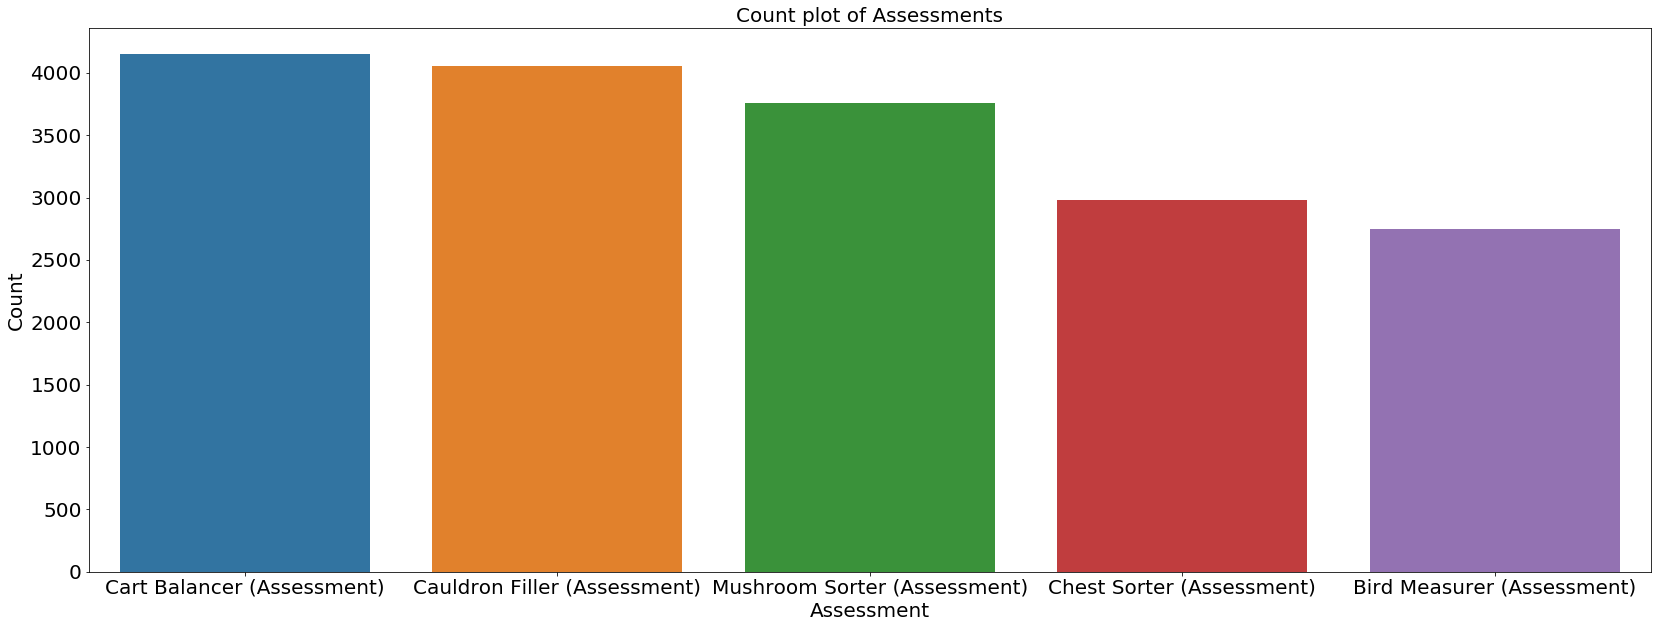

<IPython.core.display.Javascript object>

In [0]:
# Plotting Number of Title(Assessment) played
plt.figure(figsize=(28, 10))
plt.title("Count plot of Assessments")
sns.countplot(x="title", data=df_train, order=df_train["title"].value_counts().index)
plt.ylabel("Count")
plt.xlabel("Assessment")
plt.show()

We notice that the Cart Balancer(Assessment) is the most popular assessment followed by Cauldron Filler, Mushroom Sorter, Chest Sorter and Bird Measurer.

We want to know the count of worlds which the user has selected.

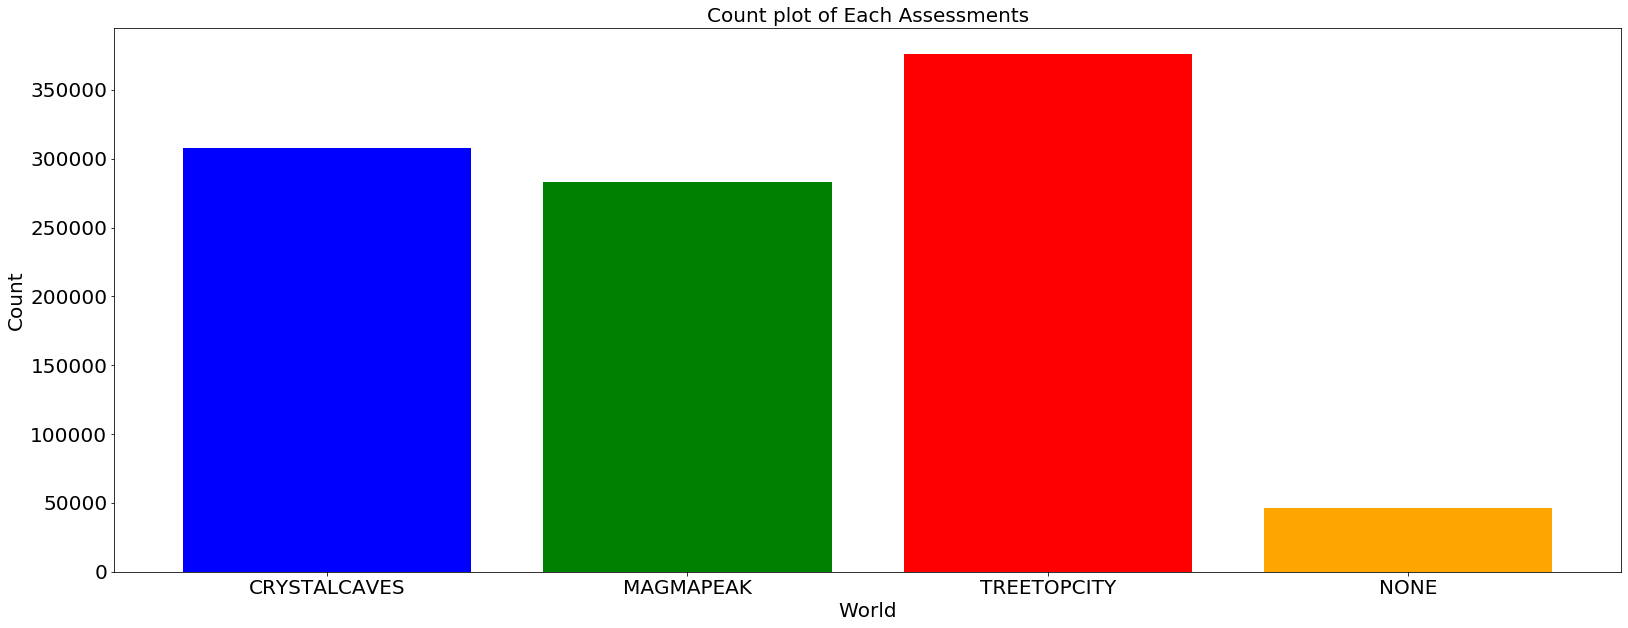

<IPython.core.display.Javascript object>

In [0]:
w_cc = df_train["world_CRYSTALCAVES"].sum()
w_mp = df_train["world_MAGMAPEAK"].sum()
w_ttc = df_train["world_TREETOPCITY"].sum()
w_n = df_train["world_NONE"].sum()
plt.figure(figsize=(27, 10))
plt.title("Count plot of Each Assessments")
plt.bar(
    ["CRYSTALCAVES", "MAGMAPEAK", "TREETOPCITY", "NONE"],
    [w_cc, w_mp, w_ttc, w_n],
    color=["blue", "green", "red", "orange"],
)
plt.ylabel("Count")
plt.xlabel("World")
plt.show()

We conclude that TreeTopCity is the most popular world, followed by CrystalCaves and MagmaPeak.

We want to know which media type is most widely consumed by the user.

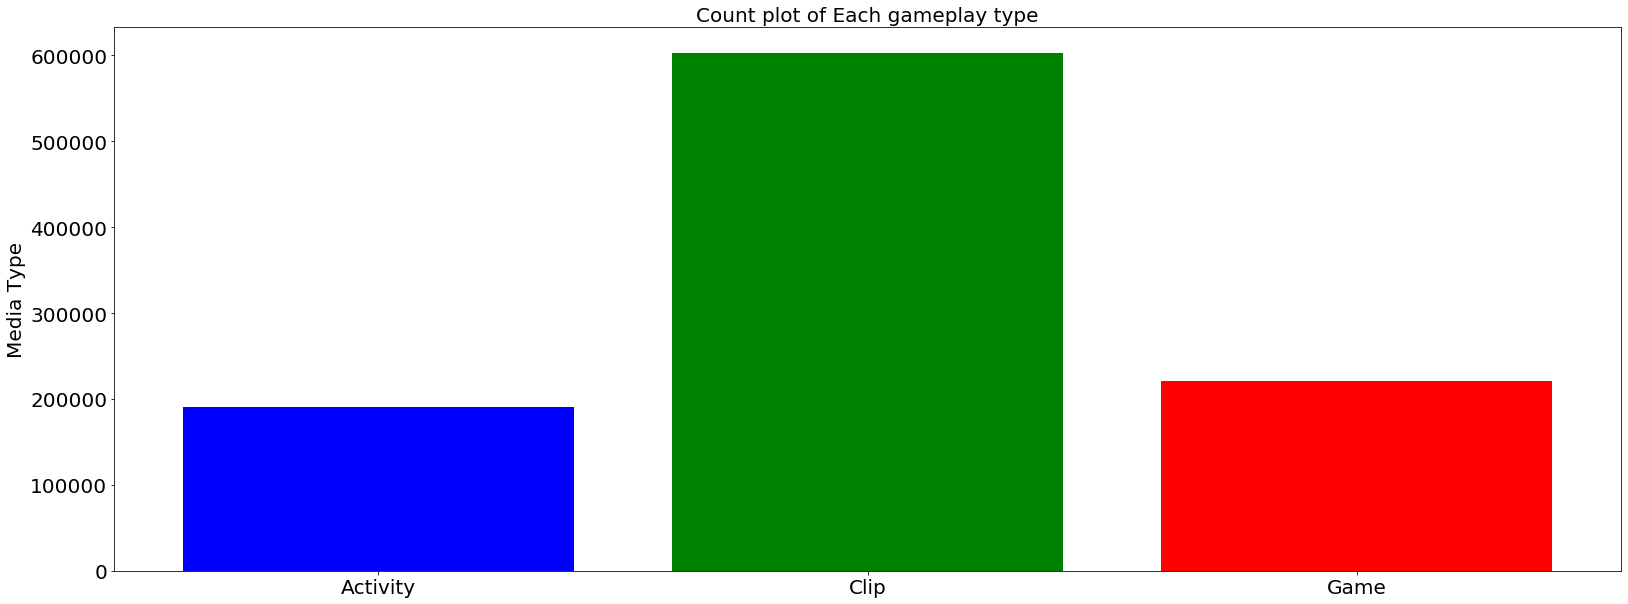

<IPython.core.display.Javascript object>

In [0]:
t_ac = df_train["type_Activity"].sum()
t_cl = df_train["type_Clip"].sum()
t_gm = df_train["type_Game"].sum()
plt.figure(figsize=(27, 10))
plt.title("Count plot of Each gameplay type")
plt.bar(
    ["Activity", "Clip", "Game"], [t_ac, t_cl, t_gm], color=["blue", "green", "red"]
)
plt.ylabel("Count")
plt.ylabel("Media Type")
plt.show()

We notice that the Clip media type is most famous, followed by Activity and Game.

We want to know what are the top 10 events which have occurred in our train dataset.

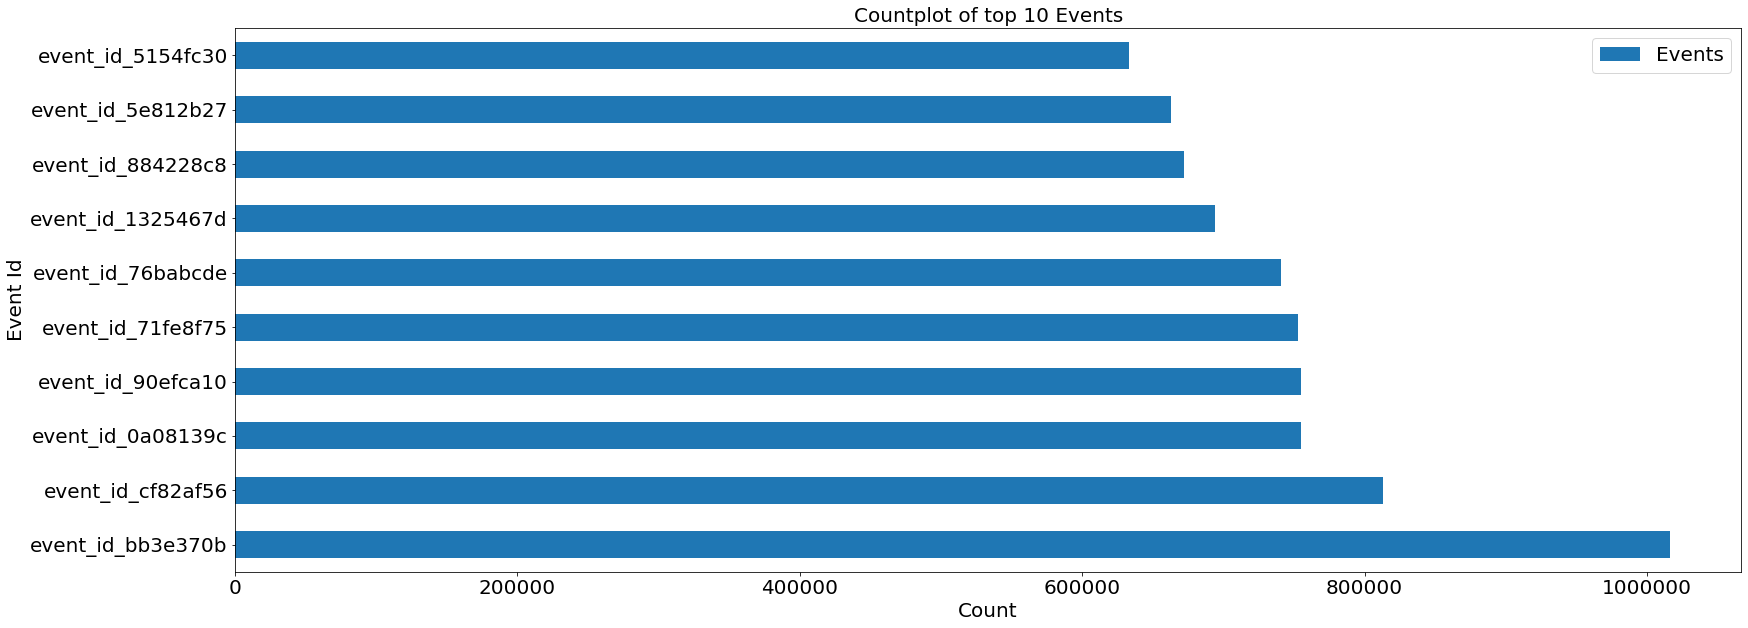

<IPython.core.display.Javascript object>

In [0]:
events = df_train.iloc[:, 3:382]

# Plotting Countplot of events
pd.DataFrame(events.sum().sort_values(ascending=False)[:10], columns=["Events"]).plot(
    kind="barh", figsize=(27, 10)
)
plt.title("Countplot of top 10 Events")
plt.xlabel("Count")
plt.ylabel("Event Id")
plt.show()

The top 10 event_ids are as shown in the above plot. Using specs file we can look up meaning of each event id.

We want to know top 10 titles, which are played the most.

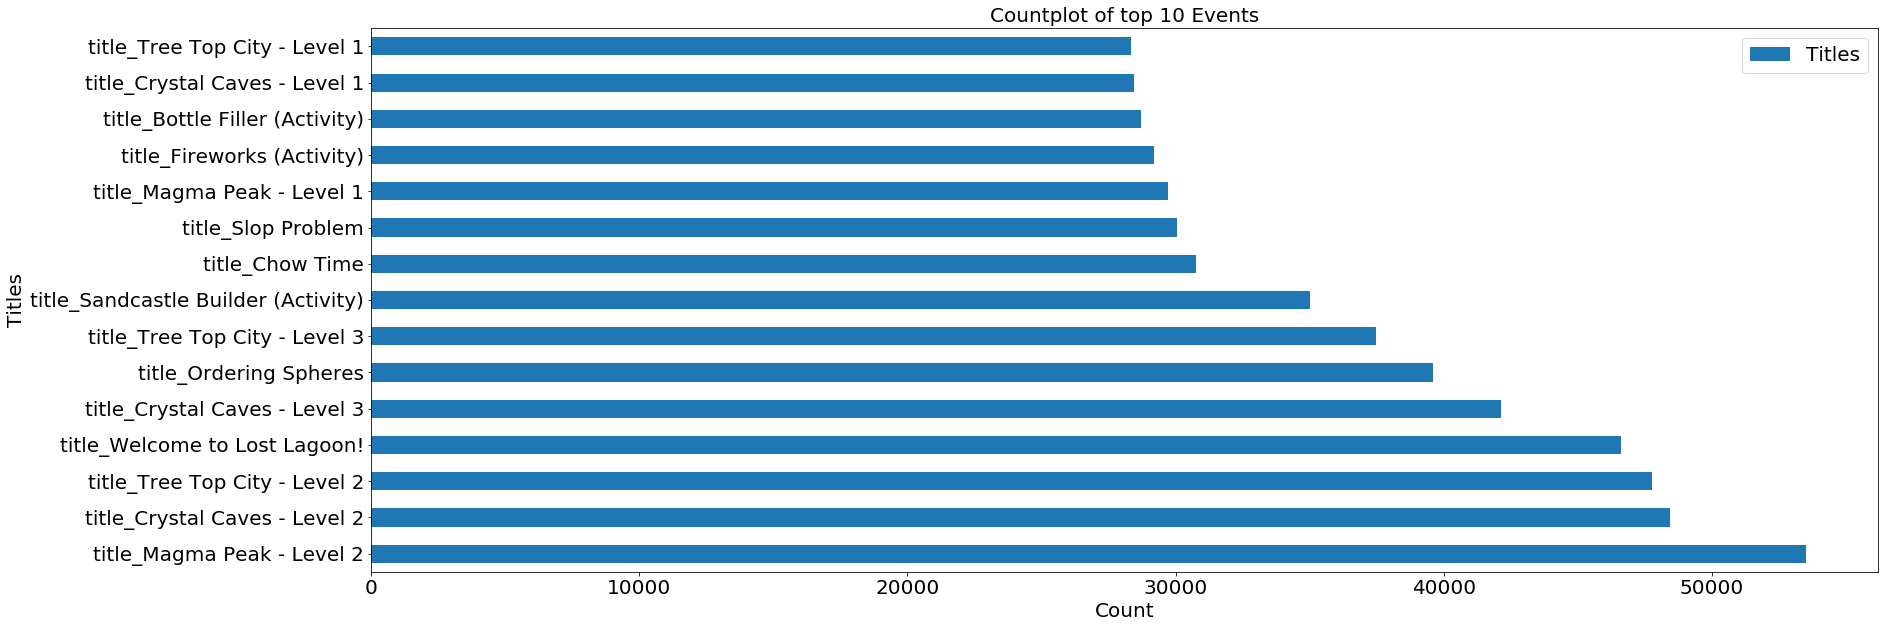

<IPython.core.display.Javascript object>

In [0]:
titles = df_train.iloc[:, 383:427]

# Plotting Countplot of events
pd.DataFrame(titles.sum().sort_values(ascending=False)[:15], columns=["Titles"]).plot(
    kind="barh", figsize=(27, 10)
)
plt.title("Countplot of top 10 Events")
plt.xlabel("Count")
plt.ylabel("Titles")
plt.show()

The top 10 titles are as shown in the above plot.

We want to know the distribution of accuracy group or target variable in our dataset.

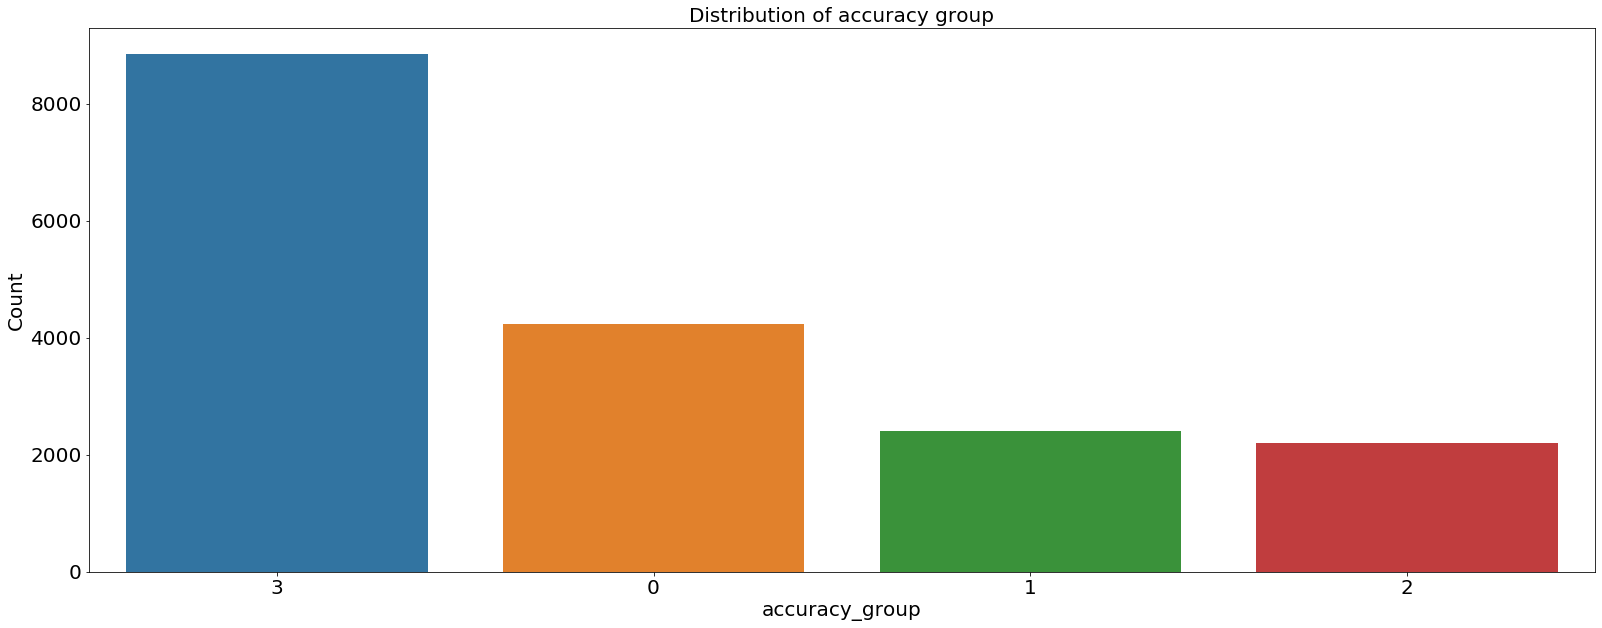

<IPython.core.display.Javascript object>

In [0]:
# Plotting distribution of accuracy group
plt.figure(figsize=(27, 10))
plt.title("Distribution of accuracy group")
sns.countplot(
    x="accuracy_group",
    data=df_train,
    order=df_train["accuracy_group"].value_counts().index,
)
plt.ylabel("Count")
plt.show()

We conclude that accuracy group 3 is more dominant in our train dataset.

We want to know how game_time affects the accuracy group:

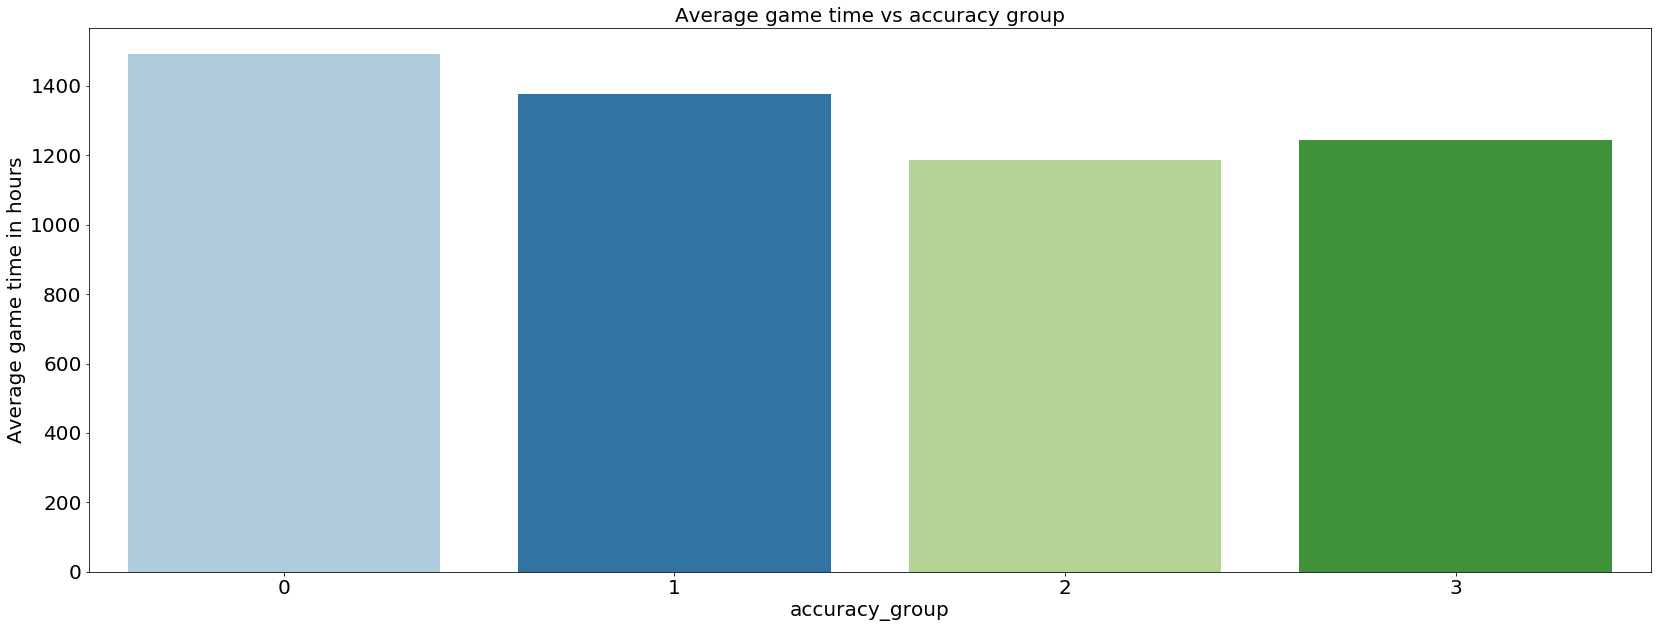

<IPython.core.display.Javascript object>

In [0]:
df_train["game_time"] = df_train["game_time"] / 3600

# Average game time vs accuracy group
plt.figure(figsize=(28, 10))
plt.title("Average game time vs accuracy group")
sns.barplot(
    x="accuracy_group",
    y="game_time",
    data=df_train,
    estimator=np.mean,
    ci=None,
    palette=("Paired"),
)
plt.ylabel("Average game time in hours")
plt.show()

Accuracy group 0 is highest, it means that kids who take more attempts to solve the assessment, play the game for a longer time period.

We want to know how clips viewed affects the accuracy group:

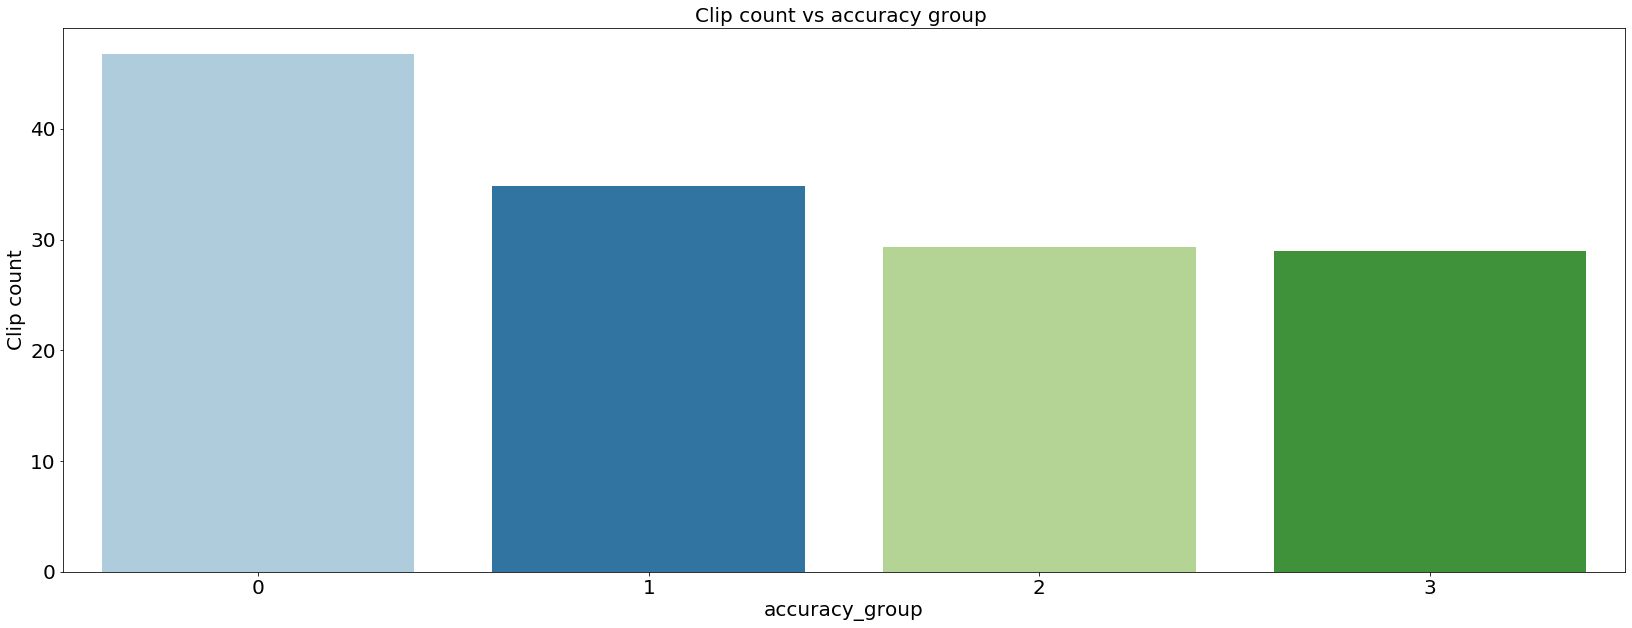

<IPython.core.display.Javascript object>

In [0]:
#  Clip count vs accuracy group
plt.figure(figsize=(28, 10))
plt.title("Clip count vs accuracy group ")
sns.barplot(
    x="accuracy_group",
    y="type_Clip",
    data=df_train,
    estimator=np.mean,
    ci=None,
    palette=("Paired"),
)
plt.ylabel("Clip count")
plt.show()

Accuracy group 0 is highest, it means that kids who watch more clips, do not perform that well.

We want to know how actvities played affect the accuracy group:

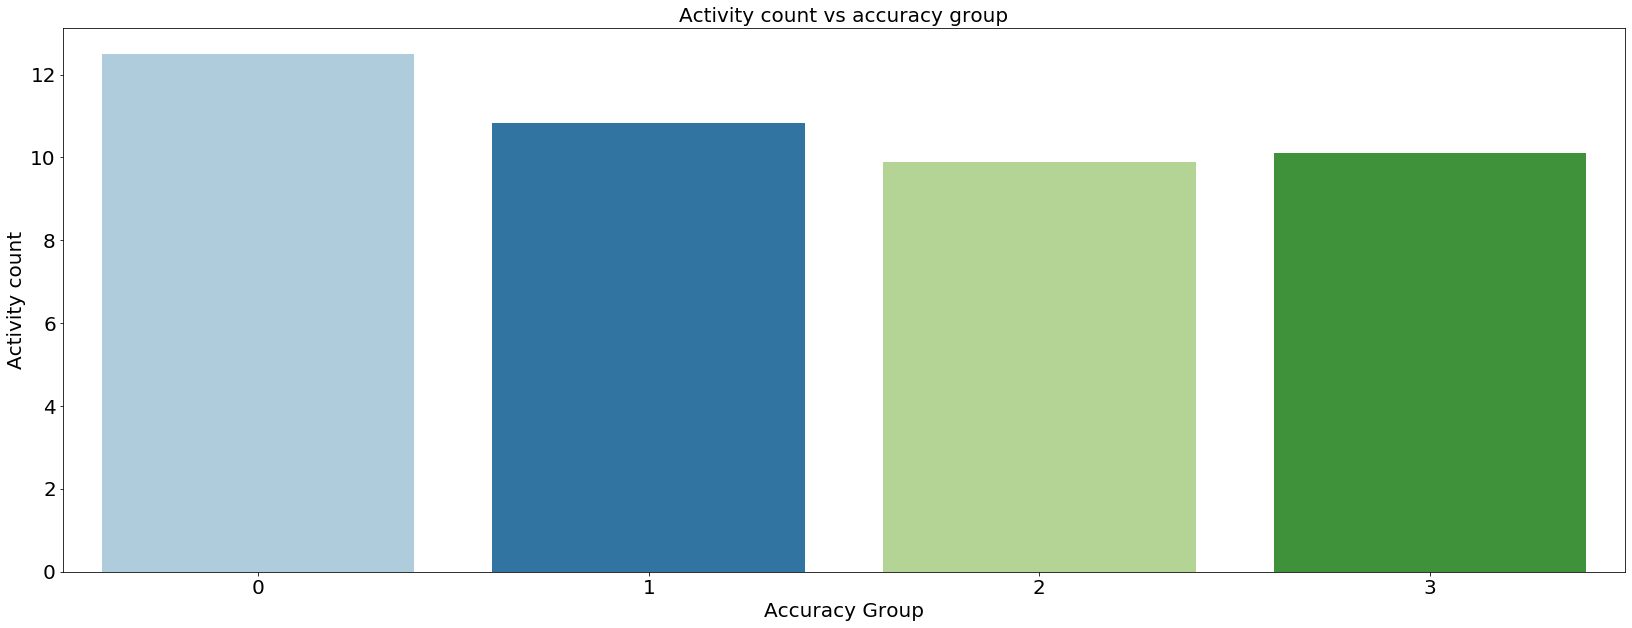

<IPython.core.display.Javascript object>

In [0]:
# Plotting Titles vs mean accuracy
plt.figure(figsize=(28, 10))
plt.title("Activity count vs accuracy group")
sns.barplot(
    x="accuracy_group",
    y="type_Activity",
    data=df_train,
    estimator=np.mean,
    ci=None,
    palette=("Paired"),
)
plt.ylabel("Activity count")
plt.xlabel("Accuracy Group")
plt.show()

Accuracy group 0 is highest, it means that kids who attempt more activities, have lower accuracy rate.

We want to know how mini games played affect the accuracy group:

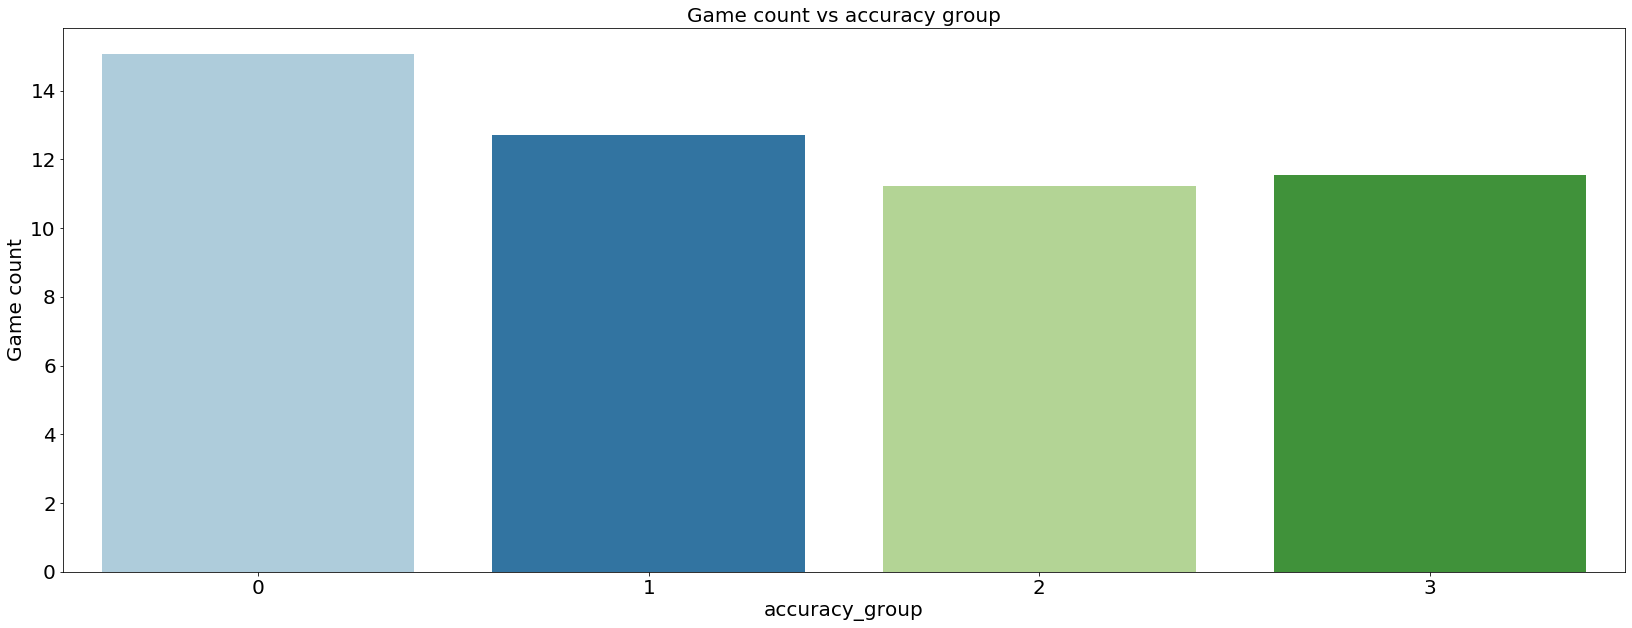

<IPython.core.display.Javascript object>

In [0]:
# Plotting Titles vs mean accuracy
plt.figure(figsize=(28, 10))
plt.title("Game count vs accuracy group")
sns.barplot(
    x="accuracy_group",
    y="type_Game",
    data=df_train,
    estimator=np.mean,
    ci=None,
    palette=("Paired"),
)
plt.ylabel("Game count")
plt.show()

Accuracy group 0 is highest, it means that kids who attempt more mini games, have lower accuracy rate.

We want to know the average accuracy rate of various assessments.

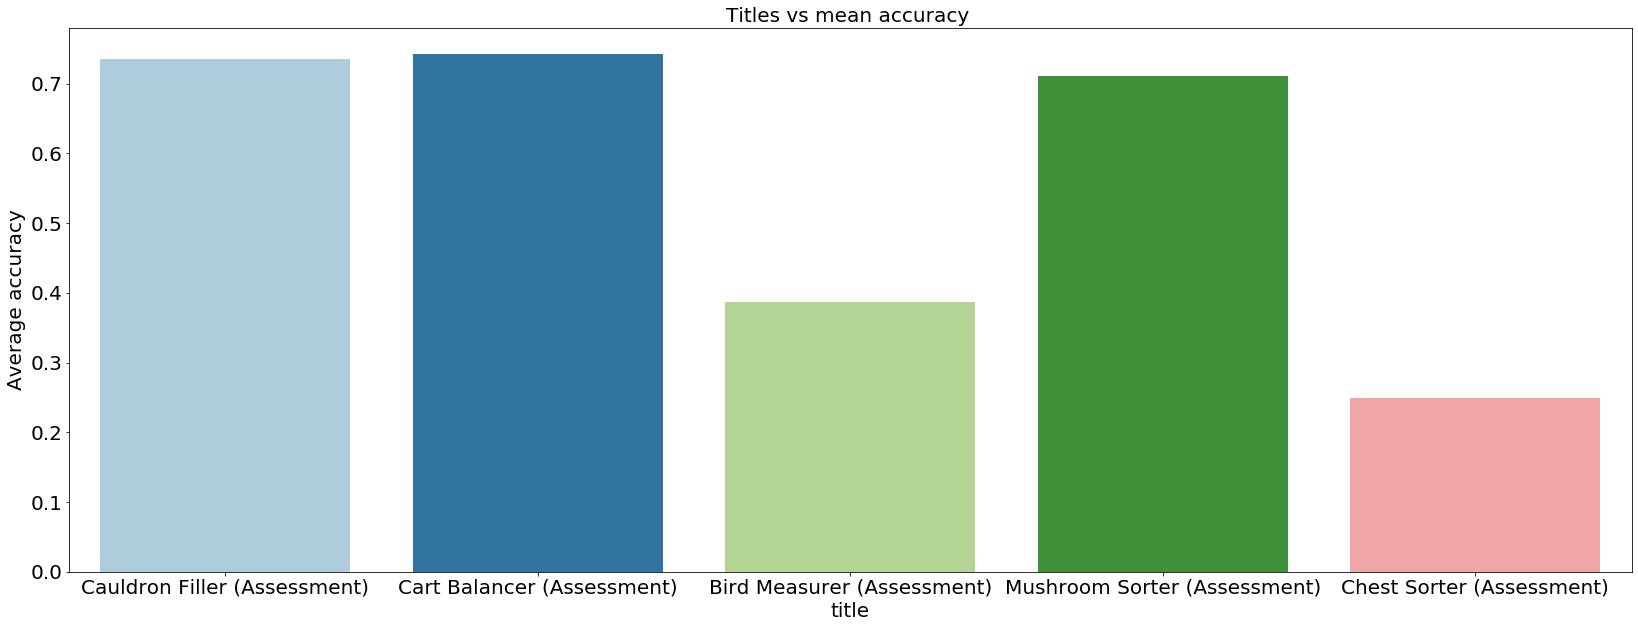

<IPython.core.display.Javascript object>

In [0]:
# Plotting Titles vs mean accuracy
plt.figure(figsize=(28, 10))
plt.title("Titles vs mean accuracy ")
sns.barplot(
    x="title",
    y="accuracy",
    data=df_train,
    estimator=np.mean,
    ci=None,
    palette=("Paired"),
)
plt.ylabel("Average accuracy")
plt.show()

We conclude that Chest Sorter and Bird measurer have the lowest accuracy rate.

We want to know in an accuracy group, the count of playing any assessment.

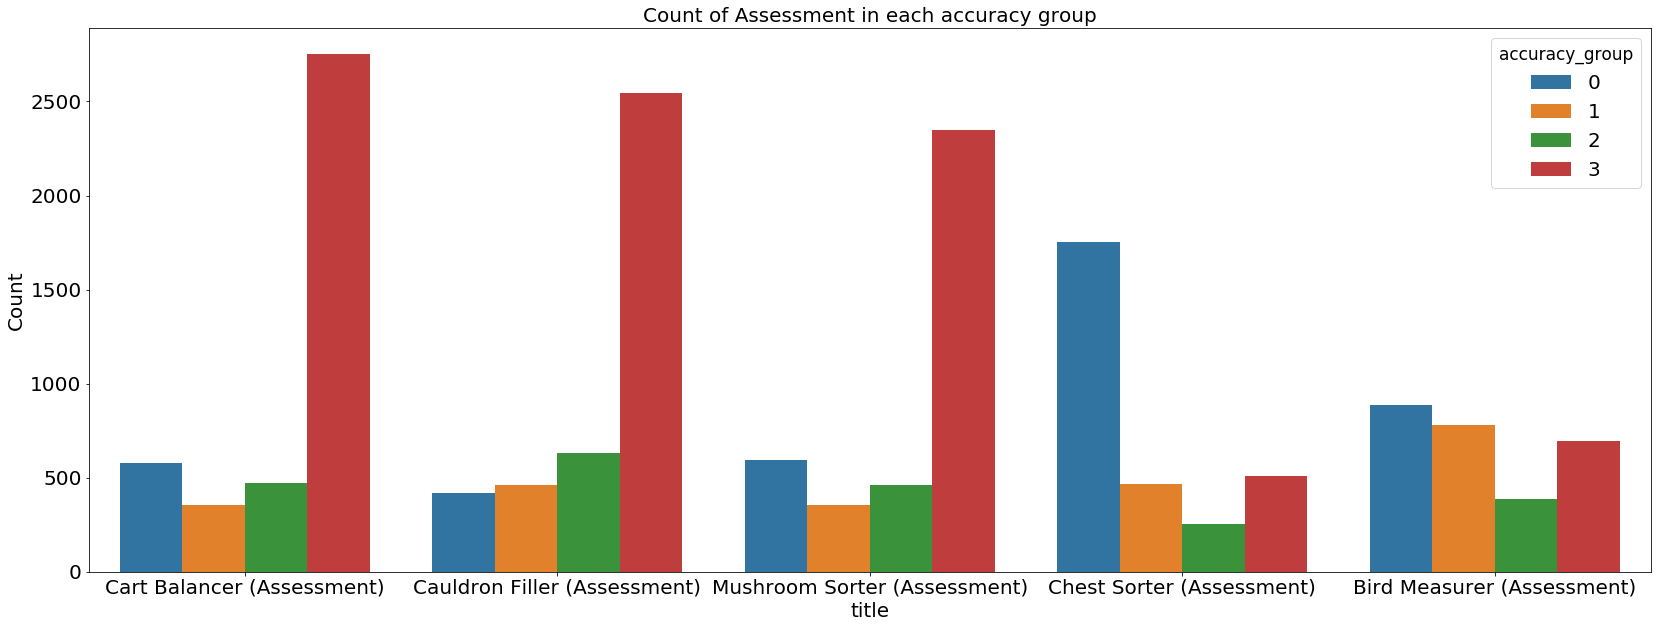

<IPython.core.display.Javascript object>

In [0]:
# Plotting Number of Title(Assessment) played
plt.figure(figsize=(28, 10))
plt.title("Count of Assessment in each accuracy group")
sns.countplot(
    x="title",
    data=df_train,
    hue="accuracy_group",
    order=df_train["title"].value_counts().index,
)
plt.ylabel("Count")
plt.show()

The distribution of game assessment according to accuracy group is shown above.

We want to know in an accuracy group, the count of playing any world.

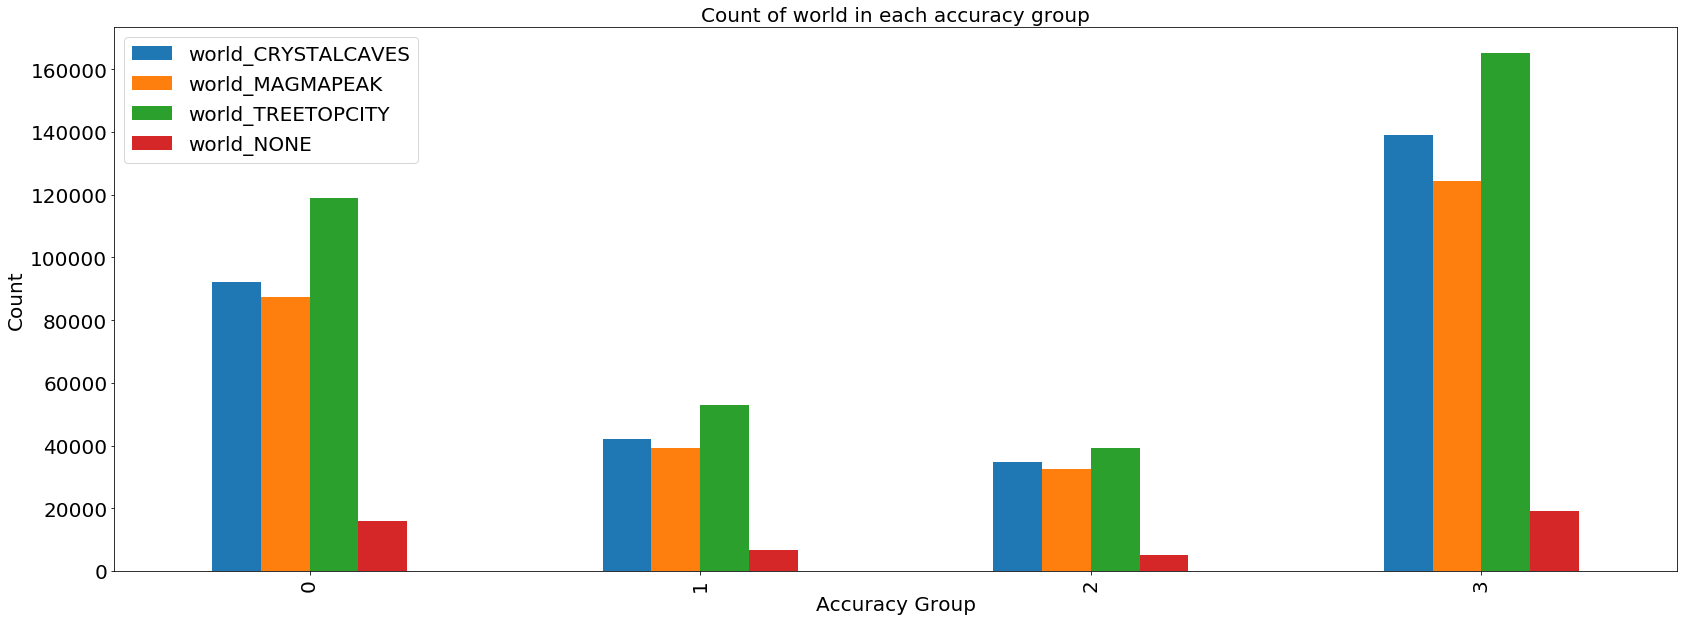

<IPython.core.display.Javascript object>

In [0]:
world_dist_accuracy_group = (
    df_train.groupby(["accuracy_group"])
    .agg(
        {
            "world_CRYSTALCAVES": sum,
            "world_MAGMAPEAK": sum,
            "world_TREETOPCITY": sum,
            "world_NONE": sum,
        }
    )
    .reset_index()
)

# Plotting Titles vs mean accuracy
world_dist_accuracy_group.plot(
    x="accuracy_group",
    y=["world_CRYSTALCAVES", "world_MAGMAPEAK", "world_TREETOPCITY", "world_NONE"],
    kind="bar",
    figsize=(28, 10),
    title="Count of world in each accuracy group",
)
plt.xlabel("Accuracy Group")
plt.ylabel("Count")
plt.show()

### Correlation Matrix

Preprocessed data has more number of features, inorder reduce the dimension of the data to model, we checked correlation between the features

In [0]:
#Correlation between the features
corrMatrix = df_train.corr()
corrMatrix

,event_count,event_id_0086365d,event_id_00c73085,event_id_01ca3a3c,event_id_022b4259,event_id_02a42007,event_id_0330ab6a,event_id_0413e89d,event_id_05ad839b,event_id_06372577,event_id_08fd73f3,event_id_08ff79ad,event_id_0a08139c,event_id_0ce40006,event_id_0d1da71f,event_id_119b5b02,event_id_1325467d,event_id_1340b8d7,event_id_14de4c5d,event_id_1575e76c,event_id_15a43e5b,event_id_15ba1109,event_id_15eb4a7d,event_id_15f99afc,event_id_16667cc5,event_id_16dffff1,event_id_19967db1,event_id_1996c610,event_id_1af8be29,event_id_1b54d27f,event_id_1bb5fbdb,event_id_1beb320a,event_id_1c178d24,event_id_1cc7cfca,event_id_1cf54632,event_id_1f19558b,event_id_2230fab4,event_id_250513af,event_id_262136f4,event_id_26a5a3dd,event_id_26fd2d99,event_id_27253bdc,event_id_28a4eb9a,event_id_28f975ea,event_id_29a42aea,event_id_29bdd9ba,event_id_29f54413,event_id_2a444e03,event_id_2a512369,event_id_2b9272f4,event_id_2c4e6db0,event_id_2dc29e21,event_id_2ec694de,event_id_2fb91ec1,event_id_30df3273,event_id_3323d7e9,event_id_33505eae,event_id_363c86c9,event_id_363d3849,event_id_36fa3ebe,event_id_37937459,event_id_37c53127,event_id_37db1c2f,event_id_3a4be871,event_id_3afde5dd,event_id_3b2048ee,event_id_3babcb9b,event_id_3bb91ced,event_id_3bb91dda,event_id_3bf1cf26,event_id_3d8c61b0,event_id_3ddc79c3,event_id_44cb4907,event_id_461eace6,event_id_46b50ba8,event_id_46cd75b4,event_id_47026d5f,event_id_47efca07,event_id_47f43a44,event_id_48349b14,event_id_4901243f,event_id_499edb7c,event_id_49ed92e9,event_id_4a09ace1,event_id_4b5efe37,event_id_4bb2f698,event_id_4c2ec19f,event_id_4d6737eb,event_id_4d911100,event_id_4ef8cdd3,event_id_51311d7a,event_id_5154fc30,event_id_53c6e11a,event_id_55115cbd,event_id_565a3990,event_id_56817e2b,event_id_56bcd38d,event_id_56cd3b43,event_id_5859dfb6,event_id_587b5989,event_id_58a0de5c,event_id_598f4598,event_id_5a848010,event_id_5be391b5,event_id_5c3d2b2f,event_id_5d042115,event_id_5e3ea25a,event_id_5e812b27,event_id_5f5b2617,event_id_6043a2b4,event_id_6088b756,event_id_611485c5,event_id_63f13dd7,event_id_65abac75,event_id_67439901,event_id_67aa2ada,event_id_69fdac0a,event_id_6aeafed4,event_id_6bf9e3e1,event_id_6c517a88,event_id_6cf7d25c,event_id_6d90d394,event_id_6f445b57,event_id_6f4adc4b,event_id_6f4bd64e,event_id_6f8106d9,event_id_7040c096,event_id_709b1251,event_id_71e712d8,event_id_71fe8f75,event_id_736f9581,event_id_7372e1a5,event_id_73757a5e,event_id_7423acbc,event_id_74e5f8a7,event_id_756e5507,event_id_763fc34e,event_id_76babcde,event_id_77261ab5,event_id_77ead60d,event_id_792530f8,event_id_7961e599,event_id_7ab78247,event_id_7cf1bc53,event_id_7d093bf9,event_id_7d5c30a2,event_id_7dfe6d8a,event_id_7ec0c298,event_id_7f0836bf,event_id_7fd1ac25,event_id_804ee27f,event_id_832735e1,event_id_84538528,event_id_84b0e0c8,event_id_857f21c0,event_id_85d1b0de,event_id_85de926c,event_id_86ba578b,event_id_86c924c4,event_id_87d743c1,event_id_884228c8,event_id_895865f3,event_id_89aace00,event_id_8ac7cce4,event_id_8af75982,event_id_8b757ab8,event_id_8d748b58,event_id_8d7e386c,event_id_8d84fa81,event_id_8f094001,event_id_907a054b,event_id_90ea0bac,event_id_90efca10,event_id_92687c59,event_id_93edfe2e,event_id_99abe2bb,event_id_99ea62f3,event_id_9b01374f,event_id_9b23e8ee,event_id_9b4001e4,event_id_9c5ef70c,event_id_9de5e594,event_id_9e34ea74,event_id_9e4c8c7b,event_id_9e6b7fb5,event_id_9ed8f6da,event_id_9ee1c98c,event_id_a0faea5d,event_id_a1192f43,event_id_a1bbe385,event_id_a29c5338,event_id_a2df0760,event_id_a44b10dc,event_id_a592d54e,event_id_a5e9da97,event_id_a6d66e51,event_id_a7640a16,event_id_a8a78786,event_id_ab3136ba,event_id_ab4ec3a4,event_id_abc5811c,event_id_ac92046e,event_id_ad148f58,event_id_b012cd7f,event_id_b120f2ac,event_id_b1d5101d,event_id_b2dba42b,event_id_b7530680,event_id_b7dc8128,event_id_b80e5e84,event_id_b88f38da,event_id_bb3e370b,event_id_bbfe0445,event_id_bc8f2793,event_id_bcceccc6,event_id_bd701df8,event_id_beb0a7b9,event_id_c0415e5c,event_id_c189aaf2,event_id_c1cac9a2,event_id_c277e121,event_id_c2baf0bd,event_id_

## Modelling <a id="modelling"></a>

As a Classification problem, we plan to experiment various classifier and identify best classifier that suit the given dataset.

From exploratory data analysis and  correlation matrix we could see most of the events id doesnt consitute to target values, so we aim to drop the feature from data. We trained whole data using random forest classifier and the event_id importance over the assesment target value is observed. Considering all these, we could able to select top 10 events that marginally influence the data, Finally below features are fed to the model


In [0]:
columns_req = ['game_time', 'prev_Ass_Bird', 'prev_Ass_cart', 'prev_Ass_cauldron',
       'prev_Ass_chest', 'prev_Ass_mushroom', 'title_12 Monkeys',
       'title_Air Show', 'title_All Star Sorting', 'title_Balancing Act',
       'title_Bottle Filler (Activity)', 'title_Bubble Bath',
       'title_Bug Measurer (Activity)',
       'title_Chicken Balancer (Activity)', 'title_Chow Time',
       'title_Costume Box', 'title_Crystal Caves - Level 1',
       'title_Crystal Caves - Level 2', 'title_Crystal Caves - Level 3',
       'title_Crystals Rule', 'title_Dino Dive', 'title_Dino Drink',
       'title_Egg Dropper (Activity)', 'title_Fireworks (Activity)',
       'title_Flower Waterer (Activity)', 'title_Happy Camel',
       'title_Heavy, Heavier, Heaviest', 'title_Honey Cake',
       'title_Leaf Leader', 'title_Lifting Heavy Things',
       'title_Magma Peak - Level 1', 'title_Magma Peak - Level 2',
 'title_Ordering Spheres',
       'title_Pan Balance', "title_Pirate's Tale", 'title_Rulers',
       'title_Sandcastle Builder (Activity)', 'title_Scrub-A-Dub',
       'title_Slop Problem', 'title_Treasure Map',
       'title_Tree Top City - Level 1', 'title_Tree Top City - Level 2',
       'title_Tree Top City - Level 3', 'title_Watering Hole (Activity)',
       'title_Welcome to Lost Lagoon!', 'type_Activity', 'type_Clip',
       'type_Game', 'world_CRYSTALCAVES', 'world_MAGMAPEAK', 'world_NONE',
       'world_TREETOPCITY','accuracy_group','event_id_27253bdc',
'event_id_1325467d',
'event_id_884228c8',
'event_id_e694a35b',
'event_id_02a42007',
'event_id_beb0a7b9',
'event_id_7372e1a5',
'event_id_b88f38da']
df_train = df_train[columns_req]
df_train.shape

(17690, 61)

In [0]:
#Set the target value
target = 'accuracy_group'

### Separating into train and test data <a id="Separating into train and test data"></a>
Training data is divided into training and validation set to compute the cross validated score for each model

In [0]:
from sklearn.model_selection import train_test_split

# Divide the training data into training (80%) and validation (20%)
df_train, df_valid = train_test_split(df_train, train_size=0.8, random_state=42, stratify=df_train[target])

In [0]:
import numpy as np
features = np.setdiff1d(df_train.columns, [target])

### Sampling of Dataset

As dataset is imbalanced, we oversampled and moderated the data for each sample.

In [0]:
#The Number of observations in each target value
import collections 
collections.Counter(df_train[target])

Counter({0: 3383, 1: 1929, 2: 1764, 3: 7076})

From the above results, we could see dataset is highly imbalanced over target class 3 compared to other class values. Lets oversample data to have equal data in each classes respectively

In [0]:
from imblearn.over_sampling import SMOTE 
X = df_train[features]
y = df_train[target]
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
import collections 
collections.Counter(y)

Counter({0: 7076, 1: 7076, 2: 7076, 3: 7076})

In [0]:
# Get the feature matrix
X_train = df_train[features].to_numpy()
X_valid = df_valid[features].to_numpy()
# Get the target vector
y_train = df_train[target].astype(int).to_numpy()
y_valid = df_valid[target].astype(int).to_numpy()

## Scaling the data

Features are scaled to standardize the data

In [0]:
from sklearn.preprocessing import StandardScaler
# The StandardScaler
ss = StandardScaler()
# Standardize the training data
X_train = ss.fit_transform(X_train)
# Standardize the validation data
X_valid = ss.transform(X_valid)

## Hyperparameter Tuning and Model Selection <a id="Hyperparameter Tuning and Model Selection"></a>

Various classifier model is trained over various parameter to get best parameter and model for our dataset

Below packages are required to run below models
- XGB - pip3 install xgboost
- catboost - pip install catboost --no-cache-dir

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

#Models are
models = {'lr': LogisticRegression(class_weight='balanced', random_state=42),
          'dtc': DecisionTreeClassifier(class_weight='balanced', random_state=42),
          'rfc': RandomForestClassifier(class_weight='balanced', random_state=42),
          'hgbc': HistGradientBoostingClassifier(random_state=42),
          'xgbc': XGBClassifier(seed=42),
          'mlpc': MLPClassifier(early_stopping=True, random_state=42),
          'catboost': CatBoostClassifier(random_state=42,loss_function='MultiClass', silent = True)
          }

## Creating the dictionary of the pipelines

In [0]:
from sklearn.pipeline import Pipeline

pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])

In [0]:
from sklearn.model_selection import PredefinedSplit

# Combine the feature matrix in the training and validation data
X_train_valid = np.vstack((X_train, X_valid))

# Combine the target vector in the training and validation data
y_train_valid = np.append(y_train, y_valid)

# Get the indices of training and validation data
train_valid_idxs = np.append(np.full(X_train.shape[0], -1), np.full(X_valid.shape[0], 0))

# The PredefinedSplit
ps = PredefinedSplit(train_valid_idxs)

### Creating the dictionary of the parameter grids

In [0]:
### Creating the dictionary of the parameter grids
param_grids = {}
#The parameter grid for logistic regression
# The grids for C
C_grids = [10 ** i for i in range(-2, 3)]

# The grids for tol
tol_grids = [10 ** i for i in range(-6, -1)]

# Update param_grids
param_grids['lr'] = [{'model__C': C_grids,
                      'model__tol': tol_grids}]

#The parameter grid for decision tree
# The grids for min_samples_split
min_samples_split_grids = [2, 30, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 30, 100]

# The grids for max_depth
max_depth_grids = range(1, 11)

# Update param_grids
param_grids['dtc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids,
                       'model__max_depth': max_depth_grids}]

#The parameter grid for random forest
# The grids for min_samples_split
min_samples_split_grids = [2, 20, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

#The parameter grid for histogram-based gradient boosting
# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 2)]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1, 20, 100]

# Update param_grids
param_grids['hgbc'] = [{'model__learning_rate': learning_rate_grids,
                        'model__min_samples_leaf': min_samples_leaf_grids}]

#The parameter grid for xgboost
# The grids for eta
eta_grids = [10 ** i for i in range(-4, 1)]

# The grids for gamma
gamma_grids = [0, 10, 100]

# The grids for lambda
lambda_grids = [10 ** i for i in range(-4, 5)]

# Update param_grids
param_grids['xgbc'] = [{'model__eta': eta_grids,
                        'model__gamma': gamma_grids,
                        'model__lambda': lambda_grids}]

#The parameter grid for multi-layer perceptron classifier
# The grids for alpha
alpha_grids = [10 ** i for i in range(-6, -1)]

# The grids for learning_rate_init
learning_rate_init_grids = [10 ** i for i in range(-5, 0)]

# Update param_grids
param_grids['mlpc'] = [{'model__alpha': alpha_grids,
                        'model__learning_rate_init': learning_rate_init_grids}]

#The parameter grid for catboost classifier
# The grids for learning_rate
learning_rate_grids = [10 ** i for i in range(-3, 2)]

# Update param_grids
param_grids['catboost'] = [{'model__learning_rate': learning_rate_grids
                        }]

### Creating the directory for the cv results.

In [0]:
import os

# Make directory
directory = os.path.dirname(abspath + '/cv_results/')
if not os.path.exists(directory):
    os.makedirs(directory)

### Hyperparameter Tuning

In [0]:
from sklearn.model_selection import GridSearchCV

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_param_estimator_gs = []

for acronym in pipes.keys():
    # GridSearchCV
    gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_micro',
                      n_jobs=2,
                      cv=10,
                      return_train_score=True)
        
    # Fit the pipeline
    gs = gs.fit(X_train_valid, y_train_valid)
    
    # Update best_score_param_estimator_gs
    best_score_param_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
    # Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
    cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
    # Get the important columns in cv_results
    important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
    # Move the important columns ahead
    cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

    # Write cv_results file
    cv_results.to_csv(path_or_buf= abspath + '/cv_results/' + acronym + '.csv', index=False)

In [0]:
# Sort best_score_param_estimator_gs in descending order of the best_score_
best_score_param_estimator_gs = sorted(best_score_param_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_param_estimator_gs
pd.DataFrame(best_score_param_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.547145,{'model__learning_rate': 0.1},(<catboost.core.CatBoostClassifier object at 0...
1,0.545789,"{'model__learning_rate': 0.1, 'model__min_samp...",(HistGradientBoostingClassifier(l2_regularizat...
2,0.541662,"{'model__eta': 0.0001, 'model__gamma': 0, 'mod...","(XGBClassifier(base_score=0.5, booster='gbtree..."
3,0.540927,"{'model__alpha': 0.01, 'model__learning_rate_i...","(MLPClassifier(activation='relu', alpha=0.01, ..."
4,0.494347,"{'model__min_samples_leaf': 1, 'model__min_sam...","((DecisionTreeClassifier(ccp_alpha=0.0, class_..."
5,0.412210,"{'model__C': 100, 'model__tol': 1e-06}","(LogisticRegression(C=100, class_weight='balan..."
6,0.390220,"{'model__max_depth': 1, 'model__min_samples_le...","(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."


Above results suggests that catboost model perform best compared to all classifier with accuracy of ~55%. We will check best features from model with radom forest feature importance. 

In [0]:
# Get the best_score, best_param and best_estimator obtained by GridSearchCV for random forest 
best_score_gs, best_param_gs, best_estimator_gs = best_score_param_estimator_gs[4]

In [0]:
# Get the dataframe of feature and importance
df_fi_rfc = pd.DataFrame(np.hstack((features.reshape(-1, 1), best_estimator_gs.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])


# Sort df_fi_rfc in descending order of the importance
df_fi_rfc = df_fi_rfc.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print df_fi_rfc
df_fi_rfc.head(10)

,Features,Importance
0,game_time,0.0670106
1,event_id_27253bdc,0.0430101
2,type_Clip,0.04285
3,world_CRYSTALCAVES,0.0342191
4,prev_Ass_cauldron,0.0336179
5,type_Game,0.0324813
6,world_TREETOPCITY,0.0311165
7,world_MAGMAPEAK,0.0303136
8,type_Activity,0.0295151
9,event_id_1325467d,0.0275201


Text(0, 0.5, 'Importance')

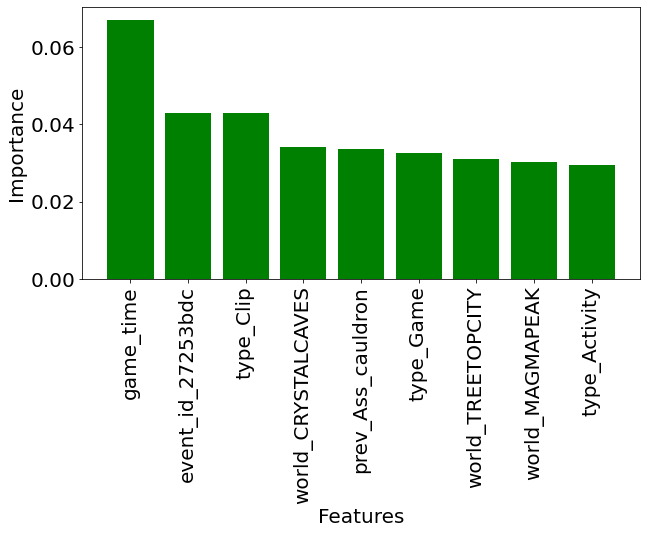

In [0]:
# Create a figure
fig = plt.figure(figsize=(10, 5))

# The bar plot of the top 5 feature importance
plt.bar(df_fi_rfc['Features'][:9], df_fi_rfc['Importance'][:9], color='green')

# Set x-axis
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')



This is similar to EDA we analysed previously, each users events count, clips watched , game played before assessment are contributing factor for outcome of his assesment result. Also we could see,kid's experience over other assesment also helps them with current assesment.

# Ensembling Methods

CV score doesnt improve much with varying parameters, so we planned to go for ensemble modeling by combining two or three models result to improve the scoring. We also made use of the best parameters identified from hyper parameter tuning. Various combination of models is trained using voting classifier, best combination and result is obtained 

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

#Models with best parameters obtained after cross validation
LR = LogisticRegression(class_weight='balanced', random_state=42,C= 0.01)
dtc = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth = 1)
rfc = RandomForestClassifier(class_weight='balanced', random_state=42,min_samples_leaf = 1)
hgbc = HistGradientBoostingClassifier(random_state=42,learning_rate = 0.1)
xgbc =  XGBClassifier(seed=42,eta = 0.0001)
mlpc = MLPClassifier(early_stopping=True, random_state=42,alpha =  1e-06)
catboost = CatBoostClassifier(random_state=42,loss_function='MultiClass',learning_rate = 0.1, silent = True)
models_para_gs = [('lr',LR),('dtc',dtc),('rfc',rfc),('hgbc',hgbc),('xgbc',xgbc),('mlpc',mlpc),('catboost',catboost)]

In [0]:
from itertools import combinations
combination= []
accuracy = 0
for i in range(len(models_para_gs)+1):
    comb_1 = list(map(list,combinations(models_para_gs,i)))
    combination.append(comb_1)

In [0]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
for combo in combination[2:]:
  for clas in combo:
    best_model = VotingClassifier(estimators=clas, voting='soft')
    best_model.fit(X_train, y_train)
    preds = best_model.predict(X_valid)
    accuracy_model = accuracy_score(y_valid, preds)
    if accuracy_model > accuracy:
      accuracy = accuracy_model
      best = clas
      model_best = best_model

In [0]:
print("Best Combination of Model for soft Voting is ")
print(best)
print("Accuracy : ",accuracy)

Best Combination of Model for soft Voting is 
[('hgbc', HistGradientBoostingClassifier(l2_regularization=0.0, learning_rate=0.1,
                               loss='auto', max_bins=255, max_depth=None,
                               max_iter=100, max_leaf_nodes=31,
                               min_samples_leaf=20, n_iter_no_change=None,
                               random_state=42, scoring=None, tol=1e-07,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False)), ('xgbc', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.0001, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subs

The Best Ensemble model obtained is "HistGradientBoosting,Multilayer Perceptron,catboost algorithm" with accuracy of 55.48%

## Conclusion<a id="conclusion"></a>

**EDA Results** 
 - Bird Measurer and Chest Sorter assesments are rare events, Kids usually prefer basic level assesment like cart balancer and cauldron filler than harder levels. 
 - TREETOPCITY is most played city by kids
 - Kids are most interetsed to watch clips compared to games and activity 
 - From history of records provided, kids are able to perform well on their first attempt and falls into the accuracy group of 3. Kids are prone to complete assesments like cart balancer, cauldron Filler at their first attempt.
 - Total time spent by group 3 is more compared to group 2 which infers kids take their time in their first assesment.  
 - Bird measurer and chest sorter have less accuracy level compared to other assesment. 

**Modelling**
- Ensemble methods and catboost model performs better with accuracy of ~56%
- Previous assesment details, event count, game time are influencing factors for predicting the target groups

**Recommendations** 

From above analysis, we could suggest kids are finding difficulities in completing chest sorter, bird measurer, if they could add more clips and activity, it will be helpful to perform better. Also, as Kids prefered to watch more clips compared to games/activity, clip contents can be improved and they could also concentrate on developing eye catching game/activity or check for issues with present content for its less usage compared to clips, so that kids can take max out of these resources as well. 

**Future Goals** 
 
Present Model produces result at accuracy of ~56%.This is mainly due to high difference on number of samples of each accuracy group. Although oversampling is performed, model couldnt able to capture perfect distinction among the accuray groups. If we able to get more samples for these records then we could able infer better details. Also in this project we have experimented only with aggregated play history of each kids. However, there are possibility event sequence plays vital role, **LSTM Model with embedding on events** can be experimented to check sequence level dominance to target prediction.Further analysis on the dataset is required to get more prominent features that constitute to the target variables like checking interval after which each game or assesment is taken, etc. 